<a href="https://colab.research.google.com/github/FilipRenschJacobsen/02456-deep-learning-with-PyTorch/blob/master/Copy_of_4_3_EXE_CIFAR_10_Filip_Cuda_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

Filip Rensch-Jacobsen: Total accuracy obtained 74,64% on the test set

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [ ]:
# I move the imports to the top of the code.. because i like it better this way

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.optim as optim

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Chaeck if GPU er avialable
torch.cuda.is_available()

True

In [ ]:
torch.cuda.current_device()

0

In [ ]:
# GPU name
torch.cuda.get_device_name(0)

'Tesla T4'

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]
--------------NB I removed that because i dont understand why it is needed.....-----------

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.
-------- Removed that part --------

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # Note to self, might be needed to allocate specifically to GPU memory
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# show train_set
train_set

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
# show test_set
test_set

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

torch.manual_seed(42) # To compare results form run to run

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True) #removed num_workers, i dont understand them
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True)

train_data_iter = iter(train_loader)
test_data_iter = iter(test_loader)
print('used classes:', classes)


used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
print("# Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(train_set.targets)))


print("\n# Test data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(test_set.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([10, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([10, 3, 32, 32])
Number of distinct labels: 10


Let us show some of the training images, for fun.



frog bird  cat ship ship truck plane  car horse  car


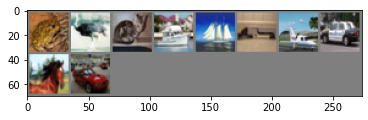

In [ ]:
# Run this cell multiple time to see more samples

class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck'] # seperate string list for classes

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize, not needed when I dont have normalized to begin with
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%4s' % classes[labels[j]] for j in range(10)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [ ]:

class Net(nn.Module):

    
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        # Your code here!
        self.conv1 = nn.Conv2d(3, 32, 5, 1, padding=2)  
        self.conv2 = nn.Conv2d(32, 64, 5, 1, padding=2)
        self.conv3 = nn.Conv2d(64, 64, 5, 1, padding=2)
        self.fc1 = nn.Linear(4*4*64, 256) #input is defined by kernal sizes, pooling and imagesize ((32-borders+padding)/2)pr layer which is pooled) 
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        #self.fc4 = nn.Linear(200,100)
        self.fc5 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        # Your code here!
        x = F.rrelu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # pool size defined as 2x2, with max defining output
        x = F.rrelu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2) # pool size defined as 2x2, with max defining output
        x = F.rrelu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2) # pool size defined as 2x2, with max defining output
        x = x.view(-1, 4*4*64) # matching by kernal sizes, pooling and imagesize to fit into the NN layer
        x = F.rrelu(self.fc1(x))
        x = F.rrelu(self.fc2(x))
        x = F.rrelu(self.fc3(x))
        #x = F.rrelu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

torch.manual_seed(42)
np.random.seed(42)
net = Net(len(used_categories))
print(net)
next(net.parameters()).is_cuda

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)


False

In [ ]:
#send the model to GPU
gpumodel = net.cuda()

In [ ]:
#test if it is cuda
next(net.parameters()).is_cuda

True

## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [ ]:
criterion = nn.CrossEntropyLoss()  # Your code here!
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)  # Your code here!

In [ ]:
#Used to look at number of parameters in the model

def count_parameters(net):
    params = [p.numel() for p in net.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(net)

  2400
    32
 51200
    64
102400
    64
262144
   256
 32768
   128
  8192
    64
   640
    10
______
460362


## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [ ]:
# Your code here!

torch.manual_seed(42)
np.random.seed(42)

num_epoch = 12   #Warning, it will take some time to run 12 epochs!!!

#evaluation variables

train_losses = []
test_losses = []
train_correct = []
test_correct = []


for epoch in range(num_epoch):  # loop over the dataset multiple times

    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = net(X_train.cuda())    #Sending train data through the model
        loss = criterion(y_pred.cuda(), y_train.cuda())    #calculating the loss between predicts and labels
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.cuda()).sum()
        trn_corr += batch_corr
        
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {epoch:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = net(X_test.cuda())

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test.cuda()).sum()
            
    loss = criterion(y_val.cuda(), y_test.cuda())
    test_losses.append(loss)
    test_correct.append(tst_corr)   

print('Finished Training')

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.55709434  accuracy:  32.190%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 0.99189997  accuracy:  39.470%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.11091673  accuracy:  44.327%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.04931509  accuracy:  48.032%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.61263430  accuracy:  50.876%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.04648471  accuracy:  66.030%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.08245575  accuracy:  66.235%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.22255993  accuracy:  66.780%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.96874171  accuracy:  67.213%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.90032655  accuracy:  67.664%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.40282881  accuracy:  73.490%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.72317010  accuracy:  73.290%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.49112248  accuracy:  73.373%
epoch:  2  b

## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

-----------The following are my own test functions---------

In [ ]:
print(test_correct) # contains the correct results of all epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # prints corrects on test sample

[tensor(6410, device='cuda:0'), tensor(6887, device='cuda:0'), tensor(7164, device='cuda:0'), tensor(7156, device='cuda:0'), tensor(7104, device='cuda:0'), tensor(7422, device='cuda:0'), tensor(7407, device='cuda:0'), tensor(7333, device='cuda:0'), tensor(7378, device='cuda:0'), tensor(7421, device='cuda:0'), tensor(7387, device='cuda:0'), tensor(7463, device='cuda:0')]

Test accuracy: 74.630%


In [ ]:
tst_corr

tensor(7463, device='cuda:0')

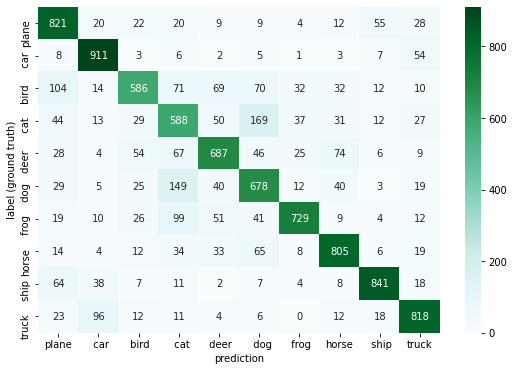

total predicted: 10000 total correct predicted: 7464


In [ ]:
# Confusion matrix to see where errors occurr on test set

# Create a loader for the entire the test set

net.to('cpu') # sending the model back to CPU

batch_size=10000
test_load_all = DataLoader(test_set, batch_size=10000, shuffle=False)

with torch.no_grad(): #dont change the gradiant in this loop
    correct = 0 #reset the number of correct predictions
    for X_test, y_test in test_load_all:
        y_val = net(X_test)
        predicted = torch.max(y_val,1)[1] # save the predictitions in predicted
        correct += (predicted == y_test).sum() # +1 when predictied are == label

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();
print(f"total predicted: {len(predicted)} total correct predicted: {correct}")

In [ ]:
#Does not work for me, for some strange reason

#images, labels = test_data_iter.next()
#images, labels = Variable(images.cuda()), Variable(labels.cuda())

# print images
#imshow(torchvision.utils.make_grid(images.cpu()))
#plt.figure(figsize=(12,4))
#plt.show()

#print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

#predicted = torch.max(outputs.data,1)
#print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(10)))

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print(f"{correct} correct out of {total}")
#print('Accuracy of the network on the {} test images: {:4.2f} %'.format(test_set.data.shape[0], 100 * correct / total))

7464 correct out of 10000


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [ ]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in test_loader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78.50 %
Accuracy of car   : 80.50 %
Accuracy of bird  : 54.50 %
Accuracy of cat   : 53.80 %
Accuracy of deer  : 68.00 %
Accuracy of dog   : 47.60 %
Accuracy of frog  : 76.40 %
Accuracy of horse : 72.00 %
Accuracy of ship  : 81.50 %
Accuracy of truck : 78.50 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**
I ended up with an accuracy on the test set of 74,64%

These are the steps I took:

Changed my activation from .relu to .rrelu improved from 61% to 65% on new pics

Added another Conv. layer (in 16- out 16.. jumps between epochs, but in the same epochs, not much learning... much slower!! and accuracy dropped from 65% to 62%

moved the Conv. layer, added a liniar nn layer, changed to 200-100-50-10 in the layers.. accuracy went to 67%

changed linar layers activation function to elu.. went from 67% to 66%

lowered learning rate to 0,0001 accuracy dropped to 53%
upped learning rate to 0,01 accuracy dropped to 45%
Learning rate 0.0009 = 65%
learning rate 0.002 = 65%

added another linear layer and added more nodes so i went 300, 200, 100, 10 

Add back normalization of the dataset (i took it out because i didnt understod what it did... and actually to my surprices accuracy improved to 68,5%

tried smaller kernal size.. accuracy dropped to 67%

tried dropou on NN layers, accuracy dropped to 66%
weight_decay= 0.001 = 67,7%

Final steps to get the high accuracy:

3 Conv layers, added way more channels so I ended up with 32 -> 64 -> 64 channels on my conv layers + i upped the kernal size from 3 to 5

4 linear layers going from 256, 128, 64, 10 nodes

What did I learn? 

I had to few output channels in my convelutional layers
Activation functions matters quite a lot
There are small gains to find with the right learning rates, weight decays etc. 
Dropout dont work on convelutional layers.. I dont know why...

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**



